In [0]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [0]:
# Generate data for long only portfolio optimization.
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [0]:
# Long only portfolio optimization.
from cvxpy import *
w = Variable(n)
gamma = Parameter(nonneg=True)
ret = mu.T*w 
risk = quad_form(w, Sigma)
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                w >= 0])

In [0]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = sqrt(risk).value
    ret_data[i] = ret.value

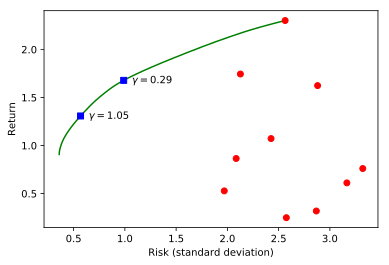

In [5]:
# Plot long only trade-off curve.
markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Risk (standard deviation)')
plt.ylabel('Return')
plt.savefig('Pareto')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


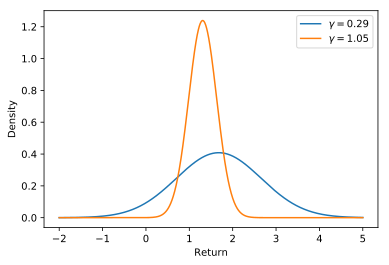

In [6]:
# Plot return distributions for two points on the trade-off curve.
import matplotlib.mlab as mlab
plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, mlab.normpdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig('Pareto_points')
plt.show()

In [0]:
# Portfolio optimization with leverage limit.
Lmax = Parameter()
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

In [0]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[k, i] = sqrt(risk).value
        ret_data[k, i] = ret.value

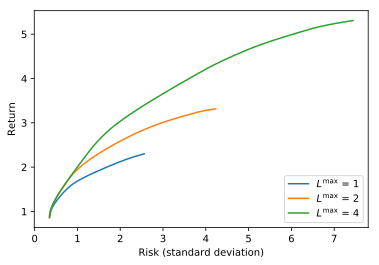

In [9]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Risk (standard deviation)')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.savefig('Pareto_lmax')
plt.show()

In [0]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = Problem(Maximize(ret), 
              [sum(w) == 1, 
               norm(w, 1) <= Lmax,
               risk <= 2])

In [0]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

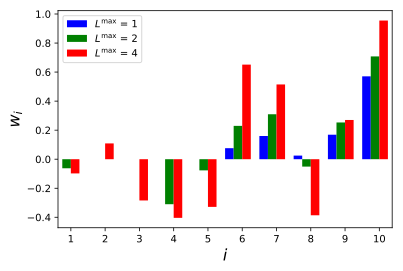

In [12]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, np.squeeze(np.asarray(w_vals[idx][indices])), color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.legend()
plt.savefig('Lmax_sparsity')
plt.show()

In [0]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [14]:
# Factor model portfolio optimization.
w = Variable(n)
f = F.T*w
gamma = Parameter(nonneg=True)
Lmax = Parameter()
ret = mu.T*w 
risk = quad_form(f, Sigma_tilde) + quad_form(w, D)
prob_factor = Problem(Maximize(ret - gamma*risk), 
                     [sum(w) == 1, 
                      norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.008e+00  -1.018e+01  +1e+01  7e-03  4e-01  1e+00  6e-01    ---    ---    1  1  - |  -  - 
 1  -1.661e+00  -4.502e+00  +4e+00  2e-03  2e-01  3e-01  2e-01  0.7197  4e-02   1  1  1 |  0  0
 2  -1.199e+00  -3.288e+00  +3e+00  1e-03  5e-02  2e-01  1e-01  0.5779  5e-01   1  1  1 |  0  0
 3  -2.267e+00  -3.325e+00  +2e+00  7e-04  2e-02  9e-02  7e-02  0.7565  3e-01   2  2  2 |  0  0
 4  -2.368e+00  -2.647e+00  +4e-01  2e-04  6e-03  2e-02  2e-02  0.7807  6e-02   2  2  2 |  0  0
 5  -2.486e+00  -2.603e+00  +2e-01  7e-05  2e-03  8e-03  7e-03  0.8733  3e-01   1  1  1 |  0  0
 6  -2.493e+00  -2.531e+00  +6e-02  2e-05  7e-04  3e-03  2e-03  0.9005  3e-01   1  1  1 |  0  0
 7  -2.517e+00  -2.523e+00  +9e-03  3e-06  1e-04  4e-04  4e-04  0.9008  7e-02   1  1  1 |  0  0
 8  -2.521e+00  -2.522e+00  +4e-04  2e-07  5e-

2.521453565722441

In [15]:
# Standard portfolio optimization with data from factor model.
risk = quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 6000, constraints m = 6002
          nnz(P) + nnz(A) = 4519500
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.1774e+04   2.65e+02   1.51e+04   1.00e-01   1.77e+01s
 200  -4.1080e+02   2.42e-01   8.86e-04   1.00e-01   2.32e+01s
 400  -1.9413e+02   1.13e-01   2.51e-04   1.00e-01   2.87

8.239572624135167